In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

In [3]:
#lendo a base de dados
df = pd.read_csv(r'data\diamonds.csv')

In [4]:
# Drop columns that are not relevant
df = df.drop(['x', 'y', 'z', 'Unnamed: 0'], axis=1)

In [5]:
# Assume the target column for classification is 'cut' (categorical column)
target = 'cut'
features = [col for col in df.columns if col != target]


In [6]:
# Define categorical and numerical features
categorical_features = ['color', 'clarity']
numerical_features = ['carat', 'depth', 'table', 'price']

In [7]:
# Preprocessing for categorical features (Ordinal Encoding)
categorical_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
])

In [8]:
# Preprocessing for numerical features (Scaling)
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [9]:
# Combine preprocessors into a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [10]:
# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(random_state=42, max_iter=500))
])

In [11]:
# Split the data
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Define hyperparameters for GridSearchCV
param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'classifier__activation': ['relu', 'tanh'],
    'classifier__solver': ['adam', 'sgd'],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate': ['constant', 'adaptive']
}


In [13]:
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Train the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['carat',
                                                                          'depth',
                                                                          'table',
                                                                          'price']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('ordinal',
                                                                                          OrdinalEncoder())]),
                                                                         ['color',
                                                                          'clarity'])])),
                                       ('classifier',
                                        MLPClassifier(max_iter=500,
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__activation': ['relu', 'tanh'],
                         'classifier__alpha': [0.0001, 0.001, 0.01],
                         'classifier__hidden_layer_sizes': [(50,), (100,),
                                                            (100, 50)],
                         'classifier__learning_rate': ['constant', 'adaptive'],
                         'classifier__solver': ['adam', 'sgd']},
             scoring='accuracy')

In [14]:
# Best parameters and performance
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validated Accuracy: {grid_search.best_score_}")

Best Parameters: {'classifier__activation': 'tanh', 'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (100, 50), 'classifier__learning_rate': 'constant', 'classifier__solver': 'adam'}
Best Cross-Validated Accuracy: 0.7278457545420838


In [15]:
#Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.7280311457174639

Classification Report:
               precision    recall  f1-score   support

        Fair       0.88      0.88      0.88       335
        Good       0.73      0.65      0.69      1004
       Ideal       0.81      0.92      0.86      4292
     Premium       0.67      0.74      0.70      2775
   Very Good       0.56      0.38      0.45      2382

    accuracy                           0.73     10788
   macro avg       0.73      0.71      0.72     10788
weighted avg       0.71      0.73      0.71     10788



[[ 295   25    5    4    6]
 [  30  657   22  113  182]
 [   1   10 3950  185  146]
 [   2   37  314 2050  372]
 [   6  167  596  711  902]]


Text(0.5, 1.0, 'Matriz de Confusão')

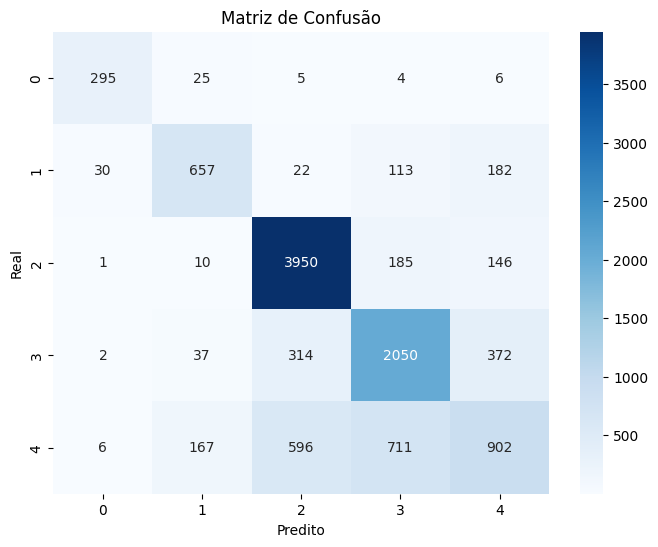

In [25]:
# lets pplot the confusion matrix
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')


In [17]:
from sklearn.model_selection import learning_curve

# Gerando a curva de aprendizado
train_sizes, train_scores, test_scores = learning_curve(pipeline, X_train, y_train, cv=5)

# Média e desvio padrão para as pontuações de teste
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)



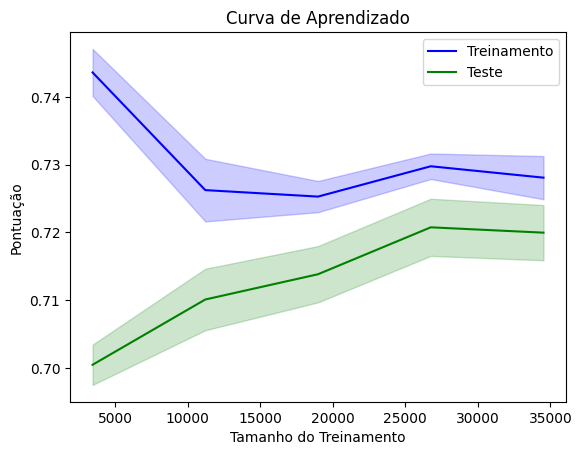

In [18]:
# Plotando a curva de aprendizado
plt.plot(train_sizes, train_mean, label='Treinamento', color='blue')
plt.plot(train_sizes, test_mean, label='Teste', color='green')

# Exibindo a área sombreada para o intervalo de erro
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.2)

plt.title("Curva de Aprendizado")
plt.xlabel("Tamanho do Treinamento")
plt.ylabel("Pontuação")
plt.legend()
plt.show()